In [1]:
### Initial notebook

In [2]:
#%pip install xarray
!python -c "import sys; print(sys.version)"

3.12.1 (main, Jan  1 1980, 12:01:00) [GCC 13.2.0]


In [3]:
from pyproj import Proj, Transformer, transform, CRS
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
#import xesmf as xe
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import glob
import os
import pandas as pd
import time
from itertools import groupby
from scipy.stats import linregress
from scipy import ndimage
from contrack import contrack
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import shapely
import shapely.ops as sops
import shapely.vectorized as sv

In [4]:
## Climate indices
def count_frost_days(tn, threshold=0.0):
    '''
    Annual count of days when TN (daily minimum temperature) < 0oC.

    Let TNijbe daily minimum temperature on day i in year j. Count the number of days where:

    TNij < 0oC.
    '''
    # Clean data (handle any non-finite values safely)
    tn_clean = tn.where(np.isfinite(tn))

    # Frost day mask and count
    frost_days = (tn_clean < threshold)
#    return frost_days.sum(dim='time', skipna=True)
    # Convert boolean to float (True=1.0, False=0.0), and sum over time
    return frost_days.astype(float).sum(dim='time', skipna=True)

def count_summer_days(tm, threshold=25.0):
    '''
    SU, Number of summer days: Annual count of days when TX (daily maximum temperature) > 25oC.

    Let TXij be daily maximum temperature on day i in year j. Count the number of days where:
    TXij > 25oC.
    '''
    # Clean data (handle any non-finite values safely)
    tm_clean = tm.where(np.isfinite(tm))

    # Assume °C by default, adjust only if unit says Kelvin
 #   if tn_clean.attrs.get('units', '').lower() in ['k', 'kelvin']:
 #       threshold += 273.15

    # Frost day mask and count
    summer_days = (tm_clean > threshold)
    return summer_days.sum(dim='time', skipna=True)

def count_icing_days(tm, threshold=0.0):
    '''
    ID, Number of icing days: Annual count of days when TX (daily maximum temperature) < 0oC.

    Let TXijbe daily maximum temperature on day i in year j. Count the number of days where:

    TXij < 0oC.
    '''
    # Clean data (handle any non-finite values safely)
    tm_clean = tm.where(np.isfinite(tm))

    # Assume °C by default, adjust only if unit says Kelvin
 #   if tn_clean.attrs.get('units', '').lower() in ['k', 'kelvin']:
 #       threshold += 273.15

    # Frost day mask and count
    icing_days = (tm_clean < threshold)
    return icing_days.sum(dim='time', skipna=True)
#def compute_TXX(tmax):
#    return tmax.groupby('time.year').max(dim='time')

def compute_dtr(tx, tn):
    """
    Compute Daily Temperature Range (DTR) as the monthly mean of (TX - TN).

    Parameters:
        tx (xarray.DataArray): Daily maximum temperature (TX), with 'time' dimension.
        tn (xarray.DataArray): Daily minimum temperature (TN), same dimensions as tx.

    Returns:
        xarray.DataArray: Monthly mean daily temperature range.
    """
    # Ensure both inputs align in time and space
    tx, tn = xr.align(tx, tn)

    # Compute daily range
    dtr_daily = tx - tn

    # Compute monthly mean DTR
    dtr_monthly = dtr_daily.resample(time='ME').mean(dim='time', skipna=True)

    # Add metadata
    dtr_monthly.name = 'DTR'
    dtr_monthly.attrs.update({
        'long_name': 'Monthly mean daily temperature range',
        'units': tx.attrs.get('units', '°C'),
        'comment': 'Mean of daily (TX - TN), where TX is max and TN is min temperature.',
        'cell_methods': 'time: mean (of daily max - min)',
    })

    return dtr_monthly
def get_max_dry_spell(seq):
    """
    Get the length of the longest consecutive run of True (dry days) in a 1D boolean array.
    """
    return max((sum(1 for _ in group) for val, group in groupby(seq) if val), default=0)


def compute_CDD(precip, threshold=1.0):
    """
    Compute the maximum length of dry spells (CDD) using groupby logic.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation with time dim.
        threshold (float): Dry day threshold in mm (default: 1.0).
    
    Returns:
        xarray.DataArray: CDD values (max dry spell length) at each grid point.
    """
    # Get dry day mask
    dry_days = (precip < threshold)

#    dry_days=dry_days.astype(float)

    # Apply the get_max_dry_spell function along 'time' using xarray.apply_ufunc
    cdd = xr.apply_ufunc(
        get_max_dry_spell,
        dry_days,
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )

    cdd.name = 'CDD'
    cdd.attrs.update({
        'long_name': 'Maximum number of consecutive dry days',
        'units': 'days',
        'comment': 'CDD is the length of the longest dry spell (RR < 1 mm)',
    })

    return cdd,dry_days

def compute_CWD(precip, threshold=1.0):
    """
    Compute the maximum length of wet spells (CWD) using groupby logic.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation with time dim.
        threshold (float): Dry day threshold in mm (default: 1.0).
    
    Returns:
        xarray.DataArray: CWD values (max dry spell length) at each grid point.
    """
    # Get dry day mask
    dry_days = (precip > threshold)

#    dry_days=dry_days.astype(float)

    # Apply the get_max_dry_spell function along 'time' using xarray.apply_ufunc
    cdd = xr.apply_ufunc(
        get_max_dry_spell,
        dry_days,
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )

    cdd.name = 'CDD'
    cdd.attrs.update({
        'long_name': 'Maximum number of consecutive wet days',
        'units': 'days',
        'comment': 'CWD is the length of the longest wet spell (RR > 1 mm)',
    })

    return cwd,wet_days

def compute_precip_exceedance(precip, start='2010', end='2023', bin_width=0.01, max_precip=1000):
    """
    Compute exceedance frequency of daily precipitation.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation (mm/day), must have 'time' dim.
        start (str): Start year.
        end (str): End year.
        bin_width (float): Width of precipitation bins (mm/day).
        max_precip (float): Upper limit of precipitation to consider (mm/day).
    
    Returns:
        bins (np.ndarray): Precipitation bin edges.
        exceedance_freq (np.ndarray): Exceedance frequency (%) for each bin.
    """
    # Select time slice
    p = precip.sel(time=slice(start, end))
    
    # Flatten across time and space
    values = p.values.flatten()
    values = values[np.isfinite(values)]  # Remove NaNs

    # Define bins
    bins = np.arange(0, max_precip + bin_width, bin_width)

    # Histogram (counts of values in each bin)
    hist, bin_edges = np.histogram(values, bins=bins)

    # Cumulative sum (reverse): exceedance count
    exceedance_counts = np.cumsum(hist[::-1])[::-1]

    # Convert to percentage
    exceedance_freq = 100 * exceedance_counts / exceedance_counts[0]

    return bins[:-1], exceedance_freq

def plot_three_maps(bias, da_4years, da_era5_4years,
                    abs_levels=np.arange(-40, 40, 4),
                    abs_cmap='RdBu_r',
                    bias_cmap='RdBu_r',
                    titles=('Bias', '4-year mean (ICON)', '13-year mean (ERA5)')):
    """
    Plot three global maps on Robinson projection:
      1) bias (diverging, centered at 0)
      2) da_4years (absolute field, shared scale with #3)
      3) da_era5_4years (absolute field, shared scale with #2)

    Parameters
    ----------
    bias, da_4years, da_era5_4years : xarray.DataArray
        Lat/lon gridded fields in PlateCarree coordinates.
    abs_levels : 1D array-like
        Contourf levels for the absolute fields (2 & 3).
    abs_cmap : str
        Colormap for the absolute fields.
    bias_cmap : str
        Colormap for the bias field.
    titles : tuple of str
        Titles for (bias, da_4years, da_era5_4years).
    """
    proj_map = ccrs.Robinson()
    data_crs = ccrs.PlateCarree()

    fig, axes = plt.subplots(3, 1, figsize=(5, 6), dpi=100,
                             subplot_kw={'projection': proj_map})

    # ---- Absolute fields share the same normalization ----
    abs_norm = BoundaryNorm(abs_levels, ncolors=plt.get_cmap(abs_cmap).N, clip=True)

    # ---- Bias uses a centered diverging norm ----
    vmax = np.nanpercentile(np.abs(bias.values), 99)  # robust symmetric range
    if not np.isfinite(vmax) or vmax == 0:
        vmax = np.nanmax(np.abs(bias.values)) if np.isfinite(np.nanmax(np.abs(bias.values))) else 1.0
    bias_norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

    # 3) da_era5_4years
    h2 = da_era5_4years.plot(ax=axes[0],
                             transform=data_crs,
                             cmap=abs_cmap,
                             levels=abs_levels,
                             norm=abs_norm,
                             cbar_kwargs={'shrink': 0.6, 'label': 'T (c)'}
                             )
    axes[0].set_title(titles[0])
    axes[0].coastlines()

    # 2) da_4years
    h1 = da_4years.plot(ax=axes[1],
                        transform=data_crs,
                        cmap=abs_cmap,
                        levels=abs_levels,
                        norm=abs_norm,
                        cbar_kwargs={'shrink': 0.6, 'label': 'T (C)'}
                        )
    axes[1].set_title(titles[1])
    axes[1].coastlines()
    
    # 1) Bias
    h0 = bias.plot(ax=axes[2],
                   transform=data_crs,
                   cmap=bias_cmap,
                   norm=bias_norm,
                   cbar_kwargs={'shrink': 0.6, 'label': 'Bias (C)'}
                   )
    axes[2].set_title(titles[2])
    axes[2].coastlines()

    # A little breathing room
    plt.tight_layout()
    return fig, (h0, h1, h2)

# 40km resolution

In [38]:
###Unstructured grid
#xr_in=xr.open_mfdataset('/capstor/store1/cscs/userlab/cwp03/zemanc/Data_Dyamond_PostProcessed/out_3/t_2m_2024*.nc')
### remaped
xr_in=xr.open_mfdataset('/capstor/store1/cscs/userlab/cwp03/zemanc/Data_Dyamond_PostProcessed/out_7/remap_t_2m_2021*.nc',{"time": 366, "lat": -1, "lon": -1})

In [39]:
### grid spacing 
#xr_in['lon'][101] -xr_in['lon'][100]
xr_in

<xarray.Dataset> Size: 145GB
Dimensions:  (time: 8760, height: 1, lat: 1440, lon: 2880)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
  * lon      (lon) float64 23kB -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 12kB -89.95 -89.83 -89.7 -89.58 ... 89.67 89.8 89.92
  * height   (height) float64 8B 2.0
Data variables:
    t_2m     (time, height, lat, lon) float32 145GB dask.array<chunksize=(24, 1, 1440, 2880), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 2.4.0 (https://...
    Conventions:               CF-1.6
    source:                    version: 2024.10; revision: spack-ci_v0.1-1084...
    institution:               Max Planck Institute for Meteorology/Deutscher...
    title:                     ICON simulation
    history:                   Wed Jul 23 16:46:15 2025: cdo -P 36 remap,/cap...
    references:                see MPIM/DWD publications
    comment:                   Praveen Kumar Pothapakula, ETHZ (ppothapa) on ...
    CDO:                       Climate Data Operators version 2.4.0 (https://...
    cdo_openmp_thread_number:  36

In [46]:
#### Unstructured grid
#gt2m=xr_in['t_2m'].isel(height_2=0 ).resample(time='D').mean()
### remapped
#gt2m=xr_in['t_2m'].isel(height=0 ).resample(time='D').mean()

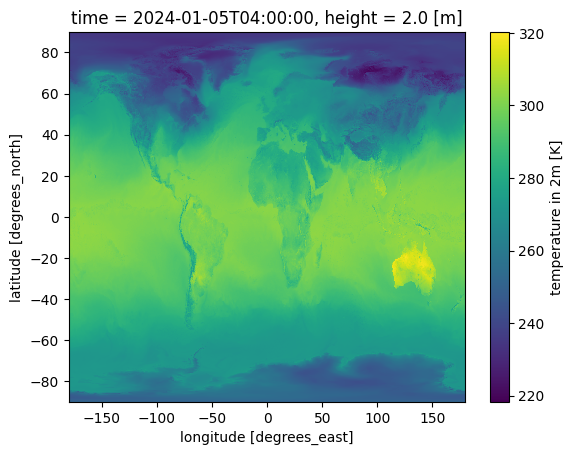

In [7]:
#one time 
xr_in['t_2m'].isel(time=100,height=0).plot()

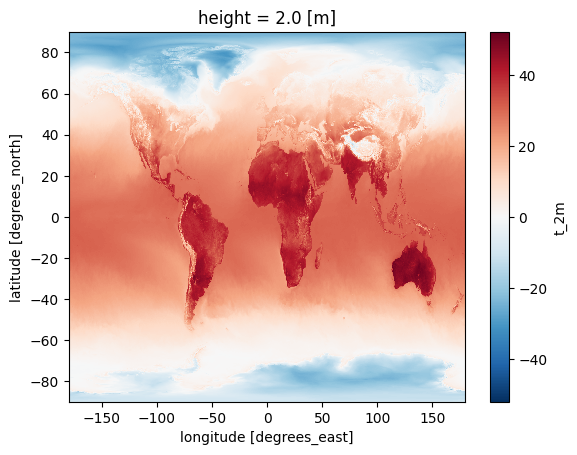

In [8]:
### max temperature
(xr_in['t_2m'].isel(height=0)-273.15).max(dim=['time']).plot()

In [32]:
### Mask to count days above the 20 (tropical nights) --> This should be minimum temperature
temp_mask = ((xr_in['t_2m'].isel(height=0)-273.15) > 20).compute() # gives true and false values (which is our mask)
#temp_mask.compute()

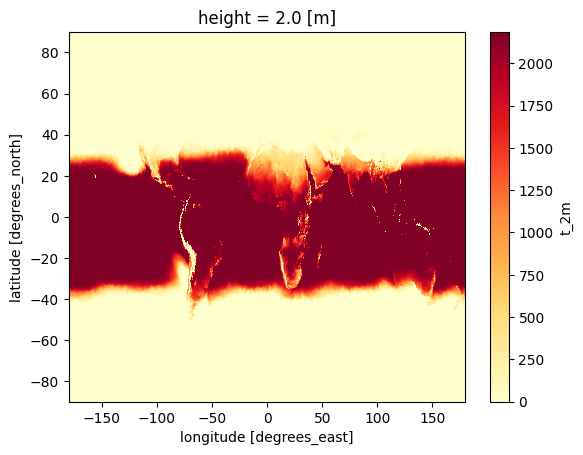

In [33]:
# Counting the days and plotting
temp_mask.sum(dim=["time"]).plot(
    cmap='YlOrRd'#, levels=np.arange(0, 200, 20)
)  # Sum up True values and plot the result

In [40]:
## Diurnal temperature range (DTR)
#1) compute max and min daily
tmin = xr_in.resample(time='1D').min().squeeze()
tmin.load()
tmin-=273 ##3 to degree 

tmax = xr_in.resample(time='1D').max().squeeze()
tmax.load()
tmax-=273 ##3 to degree 
tmax

<xarray.Dataset> Size: 6GB
Dimensions:  (lon: 2880, lat: 1440, time: 365)
Coordinates:
  * lon      (lon) float64 23kB -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 12kB -89.95 -89.83 -89.7 -89.58 ... 89.67 89.8 89.92
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    t_2m     (time, lat, lon) float32 6GB -20.34 -20.34 -20.34 ... -34.57 -34.57
Attributes:
    CDI:                       Climate Data Interface version 2.4.0 (https://...
    Conventions:               CF-1.6
    source:                    version: 2024.10; revision: spack-ci_v0.1-1084...
    institution:               Max Planck Institute for Meteorology/Deutscher...
    title:                     ICON simulation
    history:                   Wed Jul 23 16:46:15 2025: cdo -P 36 remap,/cap...
    references:                see MPIM/DWD publications
    comment:                   Praveen Kumar Pothapakula, ETHZ (ppothapa) on ...
    CDO:                       Climate Data Operators version 2.4.0 (https://...
    cdo_openmp_thread_number:  36

In [41]:
#2) Compute DTR monthly
varn='fd' 
fd=compute_dtr(tmax['t_2m'], tmin['t_2m']).astype(float)

In [45]:
###Plotting

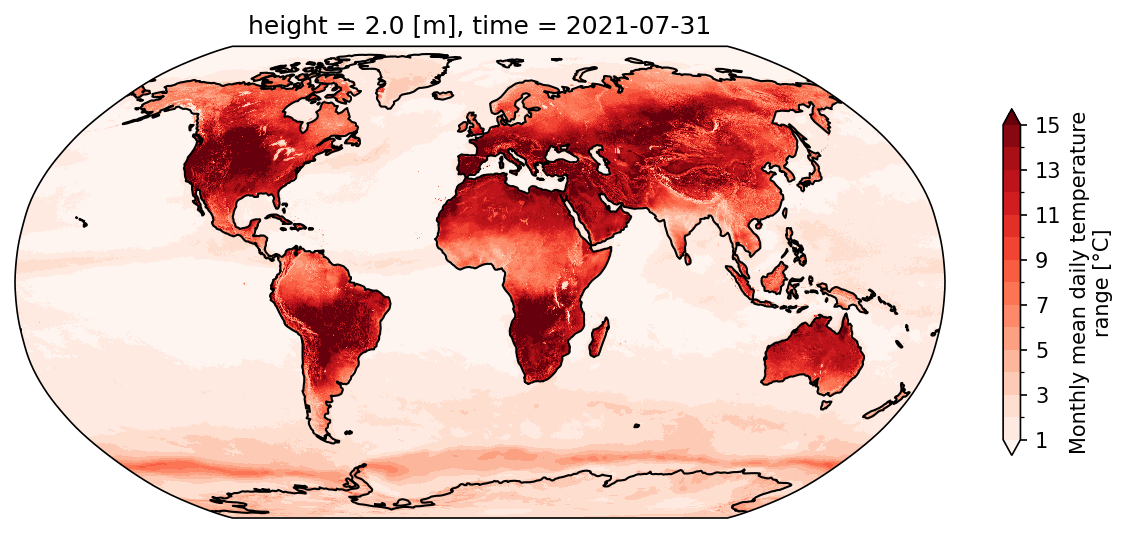

In [47]:
###one month of the year
fd_mm=fd.isel(time=6)
#fd_mm

#fd_mm.plot(cmap='Reds',levels=np.arange(1, 16, 1))
#ax.set_title(f'ICON DTR  for 2024 [time =3]');

# Create figure + axis with Robinson projection
fig, ax = plt.subplots(figsize=(10, 5),dpi=150,subplot_kw={'projection': ccrs.Robinson()})

# Plot your data on that axis
fd_mm.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # projection of your data (usually lat/lon)
    cmap='Reds',
    levels=np.arange(1, 16, 1),
    cbar_kwargs={'shrink': 0.6}
)

# Add coastlines
ax.coastlines()


# Remapped to 50 km and daily

In [5]:
da=xr.open_mfdataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/TS/t2m_day_202*',{"time": 366, "lat": -1, "lon": -1})['t_2m'].squeeze()
da

<xarray.DataArray 't_2m' (time: 1534, lat: 181, lon: 720)> Size: 800MB
dask.array<getitem, shape=(1534, 181, 720), dtype=float32, chunksize=(365, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-01-20T11:30:00 ... 2024-04-01
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    height   float64 8B 2.0
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: mean

In [6]:
#Time series

In [7]:
icon_2km_month=da.resample(time='1M').mean()
#era5_month.mean(dim=['lat', 'lon']).plot()
icon_2km_month_mean = icon_2km_month.mean(dim=["lat", "lon"]) #.compute()

# >>> Key change: ensure time chunks are >= 12
icon_2km_month_mean = icon_2km_month_mean.chunk({'time': 120})

# 12-month (1 year) rolling mean
#the window length (rolling(time=N)) depending on how much smoothing you want (e.g., 6 for half-year, 24 for 2 years).
icon_2km_smooth = icon_2km_month_mean.rolling(time=12, center=True).mean() #.compute()

/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


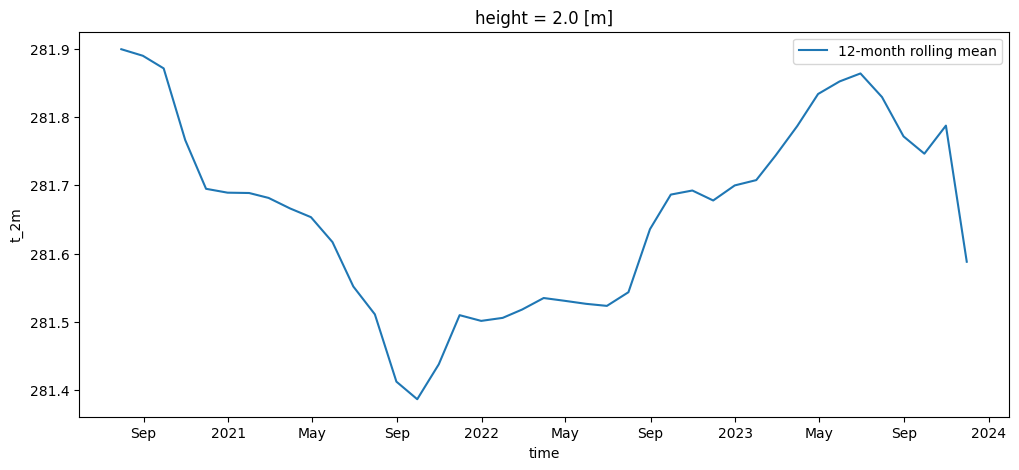

In [8]:
# Plot both raw monthly and smoothed
plt.figure(figsize=(12,5))
#icon_2km_month_mean.plot(label="Monthly mean")
icon_2km_smooth.plot(label="12-month rolling mean")
plt.legend()
plt.show()

In [9]:
### NH map mean

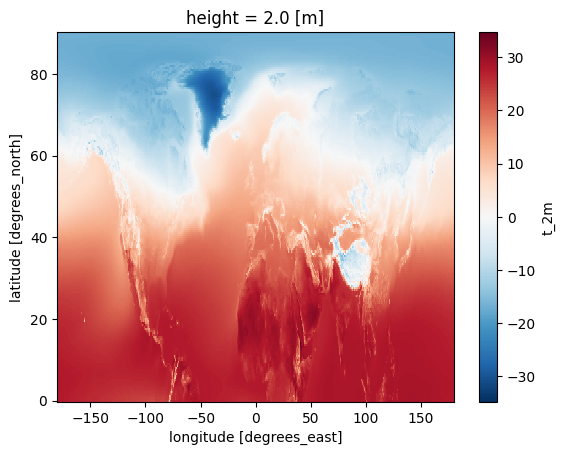

In [10]:
### mean daily mean
da_mean=(da-273.15).mean(dim=['time'])
da_mean.plot()

### max daily mean
#da_max=(da-273.15).max(dim=['time'])
#da_max.plot()

In [18]:
###

In [19]:
### Open ERA5

In [15]:
da_era5=xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_day_20*')['t2m']
da_era5 = da_era5.sel(time=slice('2010-01-01','2024-04-01'))

/tmp/ipykernel_73942/2205338830.py:1: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  da_era5=xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_day_20*')['t2m']
/tmp/ipykernel_73942/2205338830.py:1: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  da_era5=xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_day_2

In [16]:
era5_month=da_era5.resample(time='1M').mean()
#era5_month.mean(dim=['lat', 'lon']).plot()
era5_month_mean = era5_month.mean(dim=["lat", "lon"]) #.compute()

# >>> Key change: ensure time chunks are >= 12
era5_month_mean = era5_month_mean.chunk({'time': 120})

# 12-month (1 year) rolling mean
#the window length (rolling(time=N)) depending on how much smoothing you want (e.g., 6 for half-year, 24 for 2 years).
era5_smooth = era5_month_mean.rolling(time=12, center=True).mean() #.compute()

/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


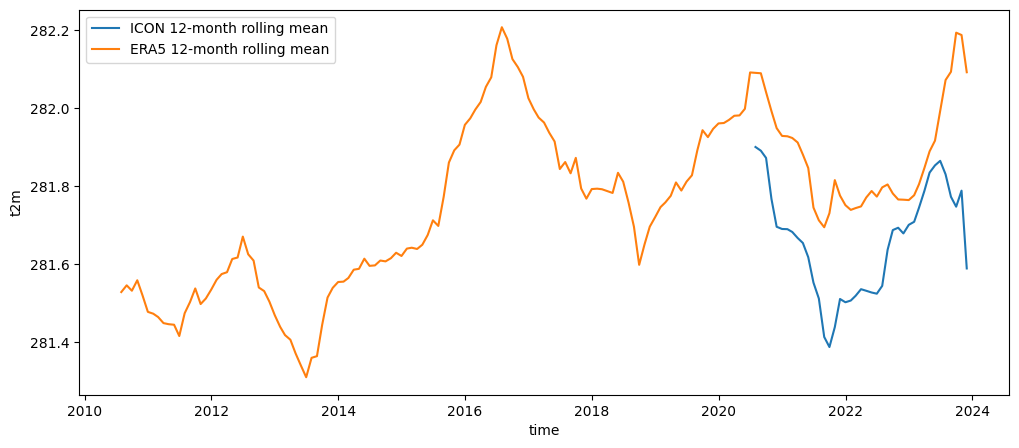

In [19]:
# Plot smoothed
plt.figure(figsize=(12,5))
icon_2km_smooth.plot(label="ICON 12-month rolling mean")
era5_smooth.plot(label="ERA5 12-month rolling mean")
plt.legend()
plt.show()

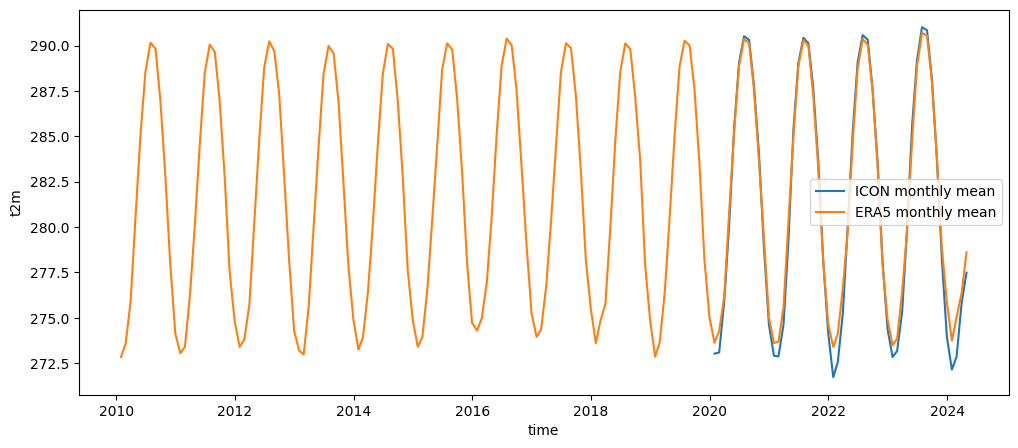

In [18]:
# Plot both raw monthly
plt.figure(figsize=(12,5))
icon_2km_month_mean.plot(label="ICON monthly mean")
era5_month_mean.plot(label="ERA5 monthly mean")
plt.legend()
plt.show()

In [21]:
### compue mean difference ERA5 vs EXCLAIM (2020 to 2023)
da_era5_4years =da_era5.sel(time=slice('2020','2023')).mean(dim=['time'])
da_4years = da.sel(time=slice('2020','2023')).mean(dim=['time'])
da_4years

<xarray.DataArray 't_2m' (lat: 181, lon: 720)> Size: 521kB
dask.array<mean_agg-aggregate, shape=(181, 720), dtype=float32, chunksize=(181, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    height   float64 8B 2.0

In [22]:
### BIAS of 4 years
bias= da_4years - da_era5_4years

In [23]:
#da_era5_4years.plot()
bias#.plot()

<xarray.DataArray (lat: 181, lon: 720)> Size: 521kB
dask.array<sub, shape=(181, 720), dtype=float32, chunksize=(181, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    height   float64 8B 2.0

In [25]:
### Plotting 3 maps

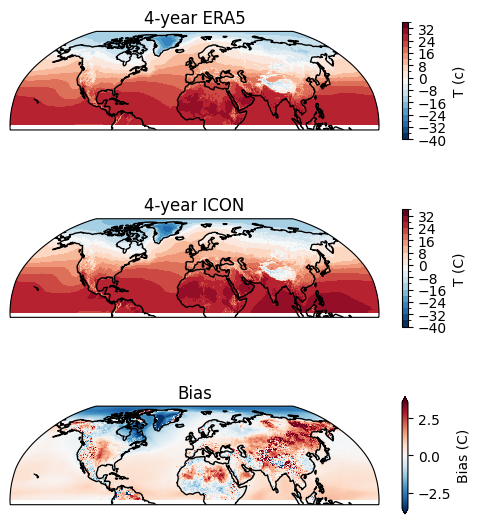

In [26]:
# ---
fig, _ = plot_three_maps(bias, da_4years-273.15, da_era5_4years-273.15,abs_levels=np.arange(-40, 40, 4), titles=('4-year ERA5','4-year ICON','Bias'))

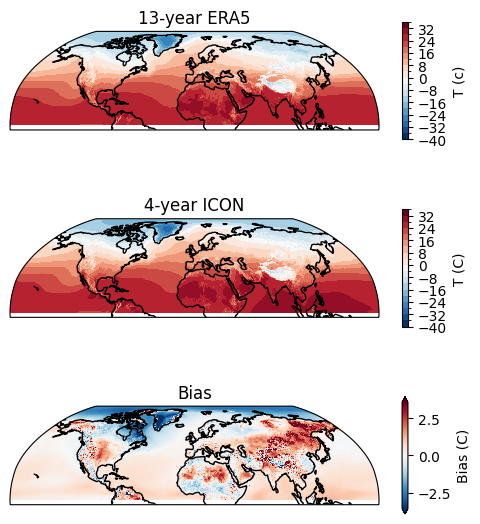

In [29]:
da_era5_23years=da_era5.mean(dim=['time'])
fig, _ = plot_three_maps(bias, da_4years-273.15, da_era5_23years-273.15,abs_levels=np.arange(-40, 40, 4),titles=('13-year ERA5','4-year ICON','Bias'))

In [51]:
### taking max of max

In [52]:
icon_max=xr.open_mfdataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/TMAX/tmax_day_202*',{"time": 366, "lat": -1, "lon": -1})['t_2m'].squeeze()
icon_max

<xarray.DataArray 't_2m' (time: 1534, lat: 181, lon: 720)> Size: 800MB
dask.array<getitem, shape=(1534, 181, 720), dtype=float32, chunksize=(365, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-01-20T11:30:00 ... 2024-04-01
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    height   float64 8B 2.0
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: maximum

In [53]:
era5_max=xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TMAX_era5/tmax_day_20*',{"time": 366, "lat": -1, "lon": -1})['t2m']
era5_max #= era5_max.sel(time=slice('2010','2023'))

<xarray.DataArray 't2m' (time: 9132, lat: 181, lon: 720)> Size: 5GB
dask.array<where, shape=(9132, 181, 720), dtype=float32, chunksize=(366, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 73kB 2000-01-01T11:00:00 ... 2024-12-31T11...
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
Attributes:
    long_name:     2 metre temperature
    units:         K
    cell_methods:  time: maximum
    institution:   ECMWF

In [54]:
### converting 2024 to compatible to the rest files

In [55]:
'''
ds=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TMAX_era5/tmax_day_2024_0p5deg.nc')#['t2m']
ds #= era5_max.sel(time=slice('2010','2023'))

# 3) Choose the main data variable (edit if you know its name)
#var = [v for v in ds.data_vars][]  # e.g., 't2m'
var ='t2m'

# --- 2) Whitelist variable attrs you want to keep ---
keep_var_attrs = {"long_name", "units", "cell_methods","institution"}  # adjust as needed
# Drop everything else (including GRIB_* and 'standard_name' if you don't want it)
new_attrs = {k: v for k, v in ds[var].attrs.items() if k in keep_var_attrs}
ds[var].attrs = new_attrs

# 2) Unify dim/coord names to exactly: time, lat, lon
rename = {}
for d in ds.dims:
    if d.lower() in ["latitude", "y"]:
        rename[d] = "lat"
    elif d.lower() in ["longitude", "x"]:
        rename[d] = "lon"
    elif d.lower() in ["valid_time", "time", "t"]:
        rename[d] = "time"
ds = ds.rename(rename)

# 7) Set the requested attributes
# Variable-level attrs
ds[var].attrs.update({
    "long_name": "2 metre temperature",
    "units": "K",
    "cell_methods": "time: maximum",
    "institution" : "ECMWF"
})

ds['t2m'].to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/TMAX_era5/tmp_tmax_day_2024_0p5deg.nc')
'''

'\nds=xr.open_dataset(\'/capstor/scratch/cscs/edolores/OBS/ERA5/TMAX_era5/tmax_day_2024_0p5deg.nc\')#[\'t2m\']\nds #= era5_max.sel(time=slice(\'2010\',\'2023\'))\n\n# 3) Choose the main data variable (edit if you know its name)\n#var = [v for v in ds.data_vars][]  # e.g., \'t2m\'\nvar =\'t2m\'\n\n# --- 2) Whitelist variable attrs you want to keep ---\nkeep_var_attrs = {"long_name", "units", "cell_methods","institution"}  # adjust as needed\n# Drop everything else (including GRIB_* and \'standard_name\' if you don\'t want it)\nnew_attrs = {k: v for k, v in ds[var].attrs.items() if k in keep_var_attrs}\nds[var].attrs = new_attrs\n\n# 2) Unify dim/coord names to exactly: time, lat, lon\nrename = {}\nfor d in ds.dims:\n    if d.lower() in ["latitude", "y"]:\n        rename[d] = "lat"\n    elif d.lower() in ["longitude", "x"]:\n        rename[d] = "lon"\n    elif d.lower() in ["valid_time", "time", "t"]:\n        rename[d] = "time"\nds = ds.rename(rename)\n\n# 7) Set the requested attribute

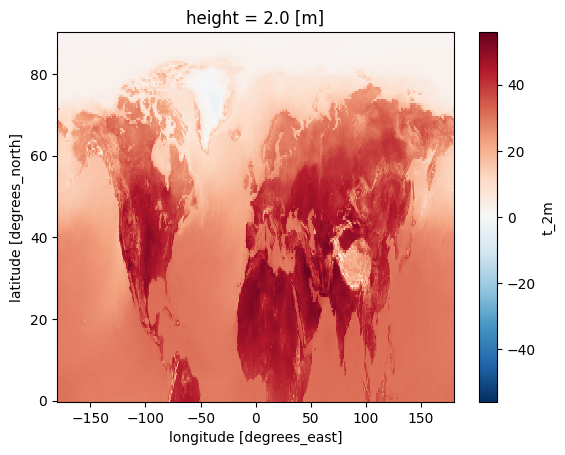

In [56]:
### max daily mean
icon_mmax=(icon_max-273.15).max(dim=['time'])
icon_mmax.plot()

In [57]:
### max daily mean
### compue mean difference ERA5 vs EXCLAIM (2020 to 2023)
era5_mmax_4years =era5_max.sel(time=slice('2020','2023')).max(dim=['time'])
icon_mmax_4years = icon_max.sel(time=slice('2020','2023')).max(dim=['time'])

### BIAS of 4 years
bias= icon_mmax_4years - era5_mmax_4years

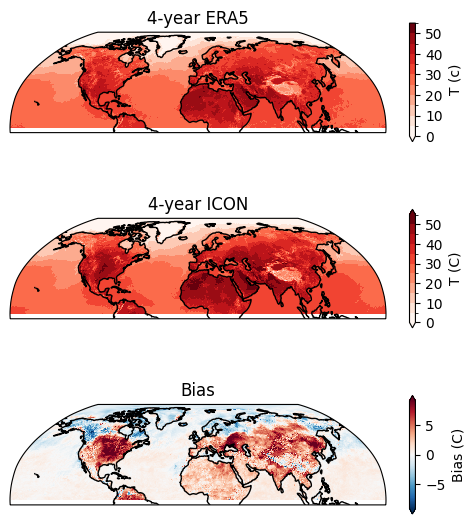

In [61]:
# --- plotting 3 maps
fig, _ = plot_three_maps(bias, icon_mmax_4years-273.15, era5_mmax_4years-273.15,abs_levels=np.arange(0, 60, 5),abs_cmap='Reds', titles=('4-year ERA5','4-year ICON','Bias'))

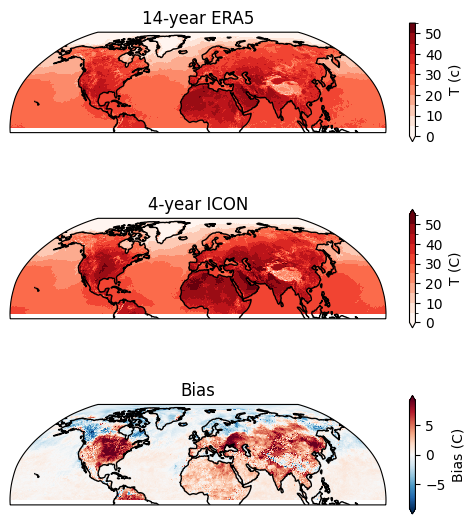

In [60]:
### 14 years
era5_mmax_14years =era5_max.max(dim=['time'])
# --- plotting 3 maps
fig, _ = plot_three_maps(bias, icon_mmax_4years-273.15, era5_mmax_4years-273.15,abs_levels=np.arange(0, 60, 5),abs_cmap='Reds', titles=('14-year ERA5','4-year ICON','Bias'))

# Traditional identifying heatwaves

In [3]:
# ----------------------------
# Helpers
# ----------------------------
# --- keep this if you already have it ---
def drop_feb29(da: xr.DataArray) -> xr.DataArray:
    is_feb29 = (da['time'].dt.month == 2) & (da['time'].dt.day == 29)
    return da.sel(time=~is_feb29)

# NEW: day-of-year remapped to 1..365 (no leap 29 Feb)
def dayofyear_365(time_index):
    doy = time_index.dt.dayofyear
    leap = time_index.dt.is_leap_year
    # shift all days after Feb 28 in leap years by -1
    return xr.where(leap & (doy > 59), doy - 1, doy)

def circular_day_distance(doy, center, period=365):
    return np.abs(((doy - center + period//2) % period) - period//2)

def compute_tr90d(
    tmax: xr.DataArray,
    ref_start: str = "1961-01-01",
    ref_end: str = "1990-12-31",
    window_halfwidth: int = 15,
    q: float = 0.90,  # fraction
) -> xr.DataArray:
    # remove Feb 29 and slice reference
    tmax_noleap = drop_feb29(tmax)
    ref = drop_feb29(tmax.sel(time=slice(ref_start, ref_end)))

    # base chunking (tune to your system)
    if ref.chunks is None:
        ref = ref.chunk({"time": 365, "lat": 90, "lon": 180})

    # IMPORTANT: use no-leap day-of-year for window selection (1..365)
    ref_doy365 = dayofyear_365(ref["time"])

    doy_vals = np.arange(1, 366)
    out = []
    for k in doy_vals:
        dist = circular_day_distance(ref_doy365, k, period=365)
        sel = ref.where(dist <= window_halfwidth, drop=True)
        # single-chunk small window along time so quantile is happy
        sel = sel.chunk({"time": -1})
        tr_k = sel.quantile(q, dim="time", skipna=True)
        out.append(tr_k)

    tr = xr.concat(out, dim=xr.DataArray(doy_vals, dims="dayofyear", name="dayofyear"))
    tr.name = f"Tr{int(q*100)}d"
    tr.attrs.update({
        "description": f"{int(q*100)}th percentile of daily Tmax (±{window_halfwidth} days) over {ref_start[:4]}–{ref_end[:4]}",
        "units": tmax.attrs.get("units", ""),
    })
    return tr

def label_runs_1d(a):
    labels, _ = ndimage.label(a.astype(np.uint8))
    return labels

def run_lengths_from_labels_1d(labels):
    if labels.size == 0:
        return labels
    max_lab = labels.max()
    if max_lab == 0:
        return np.zeros_like(labels)
    counts = np.bincount(labels, minlength=max_lab + 1)
    lengths = counts[labels]
    lengths[labels == 0] = 0
    return lengths

def detect_heatwaves(tmax: xr.DataArray, tr_by_doy: xr.DataArray, min_duration: int = 3):
    assert min_duration == 3, "This fast path is coded for min_duration=3. Ask me if you need a general N."

    # work with no-leap series
    t_noleap = drop_feb29(tmax)

    # 1..365 mapping (no 366s)
    doy365 = dayofyear_365(t_noleap.time)

    # expand Tr to full time (dask-friendly)
    tr_full = tr_by_doy.sel(dayofyear=doy365).transpose("time", "lat", "lon")
    tr_full.name = tr_by_doy.name

        # --- NEW: ensure both operands have large-enough time chunks [error of 10.10.2025]
    # (vectorized selection above often produces time chunks of size 1)
    T = t_noleap.sizes["time"]
    t_noleap = t_noleap.chunk({"time": -1})                 # or e.g. 365
    tr_full  = tr_full.chunk({"time": -1})                  # match or merge-friendly

    # hot days (exceed threshold)
    hot_mask = (t_noleap > tr_full).rename("hot_day")

    # ---- NEW: rolling trick, avoids apply_ufunc & single-chunk time ----
    end3 = hot_mask.rolling(time=3, min_periods=3).sum() == 3
    hw_mask = end3 | end3.shift(time=1, fill_value=False) | end3.shift(time=2, fill_value=False)
    hw_mask = hw_mask.rename("heatwave_day")

    return hw_mask, hot_mask, tr_full

# ----------------------------
# Seasonal split of heatwave events
# ----------------------------
def _season_masks_from_profile(hw_1d, month_1d):
    """
    Per-gridpoint numpy routine (time only).
    Inputs:
      hw_1d:   (T,) bool — heatwave day mask (already min_duration>=3)
      month_1d:(T,) int  — calendar month 1..12
    Returns:
      out: (4, T) bool for seasons [DJF, MAM, JJA, SON]
    """
    # seasons definition
    core = [
        {12, 1, 2},      # DJF
        {3, 4, 5},       # MAM
        {6, 7, 8},       # JJA
        {9, 10, 11},     # SON
    ]
    window = [
        {11, 12, 1, 2, 3},  # DJF window: Nov–Mar
        {2, 3, 4, 5, 6},    # MAM window: Feb–Jun
        {5, 6, 7, 8, 9},    # JJA window: May–Sep
        {8, 9, 10, 11, 12}, # SON window: Aug–Dec
    ]

    out = np.zeros((4, hw_1d.size), dtype=bool)
    if hw_1d.size == 0 or not np.any(hw_1d):
        return out

    # label contiguous heatwave runs
    labels, nlab = ndimage.label(hw_1d.astype(np.uint8))
    if nlab == 0:
        return out

    # iterate events
    for lab in range(1, nlab + 1):
        idx = np.nonzero(labels == lab)[0]
        if idx.size == 0:
            continue

        # count overlap in core months for each season
        counts_core = []
        for s in range(4):
            counts_core.append(np.isin(month_1d[idx], list(core[s])).sum())
        counts_core = np.asarray(counts_core)

        # choose season: argmax over core counts (ties -> first in [DJF,MAM,JJA,SON])
        s_star = int(np.argmax(counts_core))

        # keep only the days of this event that lie in the 5-month window of the assigned season
        keep = np.isin(month_1d[idx], list(window[s_star]))
        if np.any(keep):
            out[s_star, idx[keep]] = True

    return out

def split_heatwaves_by_season(hw_mask: xr.DataArray) -> xr.DataArray:
    """
    Assign each heatwave event to a season as per the 5-month window rule
    and return a per-season boolean mask of heatwave days.

    Parameters
    ----------
    hw_mask : xr.DataArray [time, lat, lon], bool
        Output `heatwave_day` from detect_heatwaves (already no-leap).

    Returns
    -------
    season_hw : xr.DataArray [season, time, lat, lon], bool
        Per-season masks with seasons = ['DJF','MAM','JJA','SON'].
        No event is double-counted across seasons.
    """
    # ensure Feb 29 removed (your detect_heatwaves already works no-leap, but be safe)
    hw = drop_feb29(hw_mask)

    # month index (1..12) aligned with hw time
    months = hw["time"].dt.month

    # make sure chunking is friendly (time-wise vector ops)
    if hw.chunks is None:
        hw = hw.chunk({"time": 365, "lat": 90, "lon": 180})

    seasons = np.array(["DJF", "MAM", "JJA", "SON"])

    # apply per pixel along time
    season_hw = xr.apply_ufunc(
        _season_masks_from_profile,
        hw.transpose("time", "lat", "lon"),
        months,
        input_core_dims=[["time"], ["time"]],
        output_core_dims=[["season", "time"]],
        output_dtypes=[bool],
        dask="parallelized",
        vectorize=True,
        output_sizes={"season": 4},
    )

    # tidy up coords and attrs
    season_hw = season_hw.assign_coords(season=("season", seasons))
    season_hw = season_hw.transpose("season", "time", "lat", "lon")
    season_hw.name = "heatwave_day_by_season"
    season_hw.attrs.update({
        "description": (
            "Heatwave days split by season using 5-month windows around each 3-month season. "
            "Events are assigned to the season where they have the most days in the core months; "
            "for that season we keep only the event's days within that season's 5-month window."
        )
    })
    return season_hw

# ===============================
# Option 2: Full-event durations per season-year
# ===============================
def _events_full_len_assign_season(hw_1d, month_1d, year_1d):
    """
    Numpy routine (time-only) to:
      - label contiguous heatwave runs,
      - compute each event's FULL duration (end - start + 1),
      - assign the WHOLE event to exactly one season by core-month majority,
      - define a season-year for the event,
      - emit per-time arrays that are ONLY filled at event END days:
          * length_at_end[T] : int (duration days), else 0
          * season_idx_at_end[T] : {0..3} for [DJF,MAM,JJA,SON], else -1
          * syear_at_end[T] : int season-year, else -1
    """
    T = hw_1d.size
    if T == 0 or not np.any(hw_1d):
        return (np.zeros(T, dtype=np.int16),
                -np.ones(T, dtype=np.int8),
                -np.ones(T, dtype=np.int32))

    # seasons & core-months
    seasons = ["DJF", "MAM", "JJA", "SON"]
    core = [
        {12, 1, 2},      # DJF
        {3, 4, 5},       # MAM
        {6, 7, 8},       # JJA
        {9, 10, 11},     # SON
    ]

    # label runs
    labels, nlab = ndimage.label(hw_1d.astype(np.uint8))

    length_at_end = np.zeros(T, dtype=np.int16)
    season_idx_at_end = -np.ones(T, dtype=np.int8)
    syear_at_end = -np.ones(T, dtype=np.int32)

    for lab in range(1, nlab + 1):
        idx = np.nonzero(labels == lab)[0]
        if idx.size == 0:
            continue

        # FULL duration (days)
        dur = idx.size

        # assign season by core-month majority (ties -> DJF,MAM,JJA,SON order)
        months_evt = month_1d[idx]
        counts = np.array([np.isin(months_evt, list(core[s])).sum() for s in range(4)])
        s_star = int(np.argmax(counts))  # 0..3

        # season-year via event midpoint (robust for cross-year events)
        mid = idx[len(idx) // 2]
        y_mid = int(year_1d[mid])
        m_mid = int(month_1d[mid])
        if s_star == 0 and m_mid == 12:  # DJF & midpoint in Dec -> next year
            syear = y_mid + 1
        else:
            syear = y_mid

        # write only at the event END day
        end_day = idx[-1]
        length_at_end[end_day] = dur
        season_idx_at_end[end_day] = s_star
        syear_at_end[end_day] = syear

    return length_at_end, season_idx_at_end, syear_at_end


def durations_full_event_per_season_year(hw_mask: xr.DataArray) -> xr.Dataset:
    """
    Compute full-event heatwave durations and aggregate by (season, season-year).

    Parameters
    ----------
    hw_mask : xr.DataArray [time, lat, lon], bool
        Heatwave day mask with min_duration already imposed (e.g., from detect_heatwaves).
        Time should be no-leap (Feb 29 removed). If not, we remove it here.

    Returns
    -------
    ds : xr.Dataset with variables:
        - mean_duration[season, season_year, lat, lon] : days per event
        - max_duration [season, season_year, lat, lon] : days
        - event_count  [season, season_year, lat, lon] : events per season-year
        - total_days   [season, season_year, lat, lon] : sum of full-event durations
      seasons = ['DJF','MAM','JJA','SON'].
      Units set in attrs.
    """
    # ensure no-leap and friendly chunking
    x = drop_feb29(hw_mask).astype(bool)
    if x.chunks is None:
        x = x.chunk({"time": 365, "lat": 90, "lon": 180})

    months = x["time"].dt.month.astype("int16")
    years  = x["time"].dt.year.astype("int32")

    # vectorized per-pixel apply over time
    (length_at_end, season_idx_at_end, syear_at_end) = xr.apply_ufunc(
        _events_full_len_assign_season,
        x.transpose("time", "lat", "lon"),
        months,
        years,
        input_core_dims=[["time"], ["time"], ["time"]],
        output_core_dims=[["time"], ["time"], ["time"]],
        output_dtypes=[np.int16, np.int8, np.int32],
        vectorize=True,
        dask="parallelized",
    )

    # set names & coords
    length_at_end = length_at_end.rename("length_at_end").transpose("time", "lat", "lon")
    season_idx_at_end = season_idx_at_end.rename("season_idx_at_end").transpose("time", "lat", "lon")
    syear_at_end = syear_at_end.rename("season_year_at_end").transpose("time", "lat", "lon")

    # Convenience: build a categorical-like selector per season
    seasons = np.array(["DJF","MAM","JJA","SON"])

    out = []

    for s_idx, s_name in enumerate(seasons):
        sel = (season_idx_at_end == s_idx)

        # keep only ends for this season
        len_sel = xr.where(sel, length_at_end, np.nan)

        # labels (season-year) — compute ONLY the labels to avoid the groupby-on-chunked error
        syear_labels = xr.where(sel, syear_at_end, np.nan).astype("float64").compute()

        # attach labels as a coordinate along time
#        len_lab = len_sel.assign_coords(season_year=("time", syear_labels))
#        len_lab = len_sel.assign_coords(season_year=("time", syear_labels.data))
        len_lab = len_sel.assign_coords(season_year=(len_sel.dims, syear_labels.data))

        # aggregate per season_year (xarray will create a "season_year" dimension)
        mean_dur = len_lab.groupby("season_year").mean().rename("mean_duration")

        max_dur  = len_lab.groupby("season_year").max().rename("max_duration")

        

        # event count: count of ends (True) per season_year
#        ends_lab = sel.assign_coords(season_year=("time", syear_labels))
#        ends_lab = sel.assign_coords(season_year=("time", syear_labels.data))
        ends_lab = sel.assign_coords(season_year=(sel.dims, syear_labels.data))

#        n_evt = ends_lab.groupby("season_year").sum("time").rename("event_count")
        n_evt    = ends_lab.groupby("season_year").sum().rename("event_count")
        
        # total days: sum of full-event durations at ends
#        total_days = len_lab.groupby("season_year").sum("time").rename("total_days")
        total_days = len_lab.groupby("season_year").sum().rename("total_days")

        # stack into one dataset and tag the season
        ds_s = xr.Dataset(
            dict(mean_duration=mean_dur, max_duration=max_dur,
                 event_count=n_evt, total_days=total_days)
        ).assign_coords(season=s_name).expand_dims("season")

        out.append(ds_s)

    ds = xr.concat(out, dim="season").sortby("season_year")
    ds = ds.assign_coords(season=("season", seasons))

    # tidy attrs / units
    ds["mean_duration"].attrs.update({
        "long_name": "Mean full-event duration",
        "units": "days per event",
        "description": "Average duration of heatwave events (full length), grouped by season and season-year."
    })
    ds["max_duration"].attrs.update({
        "long_name": "Max full-event duration",
        "units": "days",
    })
    ds["event_count"].attrs.update({
        "long_name": "Number of heatwave events",
        "units": "events per season-year",
    })
    ds["total_days"].attrs.update({
        "long_name": "Total heatwave days from full-event durations",
        "units": "days",
        "note": "Sum of full-event durations for events assigned to the season-year.",
    })

    return ds


In [4]:
tmax=xr.open_mfdataset('/capstor/scratch/cscs/edolores/old_icon/tmax_2m/remap_tmax_2m_*',{"time": 366, "lat": 181, "lon": 720})['tmax_2m'].squeeze()
#tmax = tmax.chunk({"time": 366, "lat": 181, "lon": 720})  # adjust to your RAM/cluster
tmax=tmax.sel(lat=slice(0,90)) # Northern hemisphere
tmax

<xarray.DataArray 'tmax_2m' (time: 4383, lat: 180, lon: 720)> Size: 2GB
dask.array<getitem, shape=(4383, 180, 720), dtype=float32, chunksize=(366, 179, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 35kB 2006-01-01T09:00:00 ... 2017-12-31T09...
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 1kB 0.25 0.75 1.25 1.75 ... 88.25 88.75 89.25 89.75
    height   float64 8B 2.0
Attributes:
    standard_name:  tmax_2m
    long_name:      Max 2m temperature
    units:          K
    param:          0.0.0
    cell_methods:   time: maximum

In [38]:
# ----------------------------
# Main pipeline
# ----------------------------
# 1) Compute Tr90d on 2020–2024 (±15 days => 31-day window) (own climatology)
tr90d = compute_tr90d(tmax, ref_start="2014-01-20", ref_end="2017-04-01",
                      window_halfwidth=15, q=0.90)

## open 90th percentile created from ERA5 1961–1990 
###
#tr90d=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/TR90d_1961_1990.nc')['Tr90d']
#tr90d#.isel(dayofyear=100).plot()

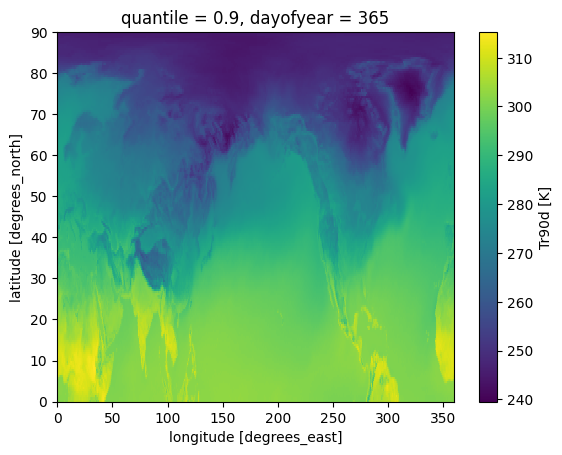

In [39]:
tr90d.isel(dayofyear=364).plot()

In [40]:
### select a smaller time period [this is simlar to the simulation]
tmax=tmax.sel(time=slice('2013-01-20','2017-04-01'))

# 2) Detect heatwaves across the full record (1959–2023)
hw_mask, hot_mask, tr_full = detect_heatwaves(tmax, tr90d, min_duration=3)

In [47]:
### Saving
hw_mask.to_netcdf('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/hw_mask_simclim.nc')
hot_mask.to_netcdf('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/hot_mask_simclim.nc')
tr_full.to_netcdf('/capstor/scratch/cscs/edolores/old_icon//Heatwaves/Russo/tr_full_simclim.nc')
### Opening saved data
#hw_mask=xr.open_dataset('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/hw_mask.nc')['heatwave_day']
#hot_mask=xr.open_dataset('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/hot_mask.nc')['hot_day']
#tr_full=xr.open_dataset('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/tr_full.nc')['Tr90d']
#tmax

In [42]:
# ----------------------------
# Optional: yearly diagnostics
# ----------------------------
# Use the no-leap time axis to match hw_mask
t_noleap = drop_feb29(tmax)

### error from 14.10.2025:
# before the rolling in detect_heatwaves
#t_noleap = drop_feb29(tmax).chunk({'time': -1, 'lat': 90, 'lon': 180})

# (a) number of heatwave days per year
hw_days_per_year = hw_mask.resample(time="YS").sum("time")
hw_days_per_year.name = "heatwave_days"

In [43]:
#hw_days_per_year.isel(time=0).plot()

In [44]:
#orginal
mean_hw_days=hw_days_per_year.mean(dim='time')#.plot()#levels=np.arange(0,30,3))

### error from 14.10.2025:
# Example: mean number of heatwave days per year at each grid point
#mean_hw_days = (hw_mask.astype('i1').resample(time='YS').sum('time').mean('time'))

In [45]:
'''
### Full map
proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})
plot=mean_hw_days.plot(ax=ax1, cmap='YlOrRd', levels=np.arange(0,300,30),transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})
# Add features
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
'''

'\n### Full map\nproj = ccrs.Robinson(central_longitude=0, globe=None)\n\nfig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={\'projection\': proj})\nplot=mean_hw_days.plot(ax=ax1, cmap=\'YlOrRd\', levels=np.arange(0,300,30),transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})\n# Add features\nax1.add_feature(cfeature.NaturalEarthFeature(\'physical\', \'land\', \'50m\', \n                                            edgecolor=\'face\', facecolor=\'grey\', alpha=0.30), zorder=20)\n'

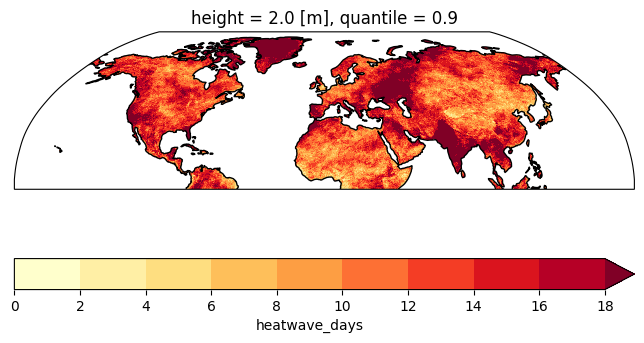

In [46]:
## masking

# --- names of coords ---
lat_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lat'))
lon_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lon'))

# --- 2D lon/lat matching your DataArray's grid & dim order ---
# These come back with dims ordered consistently (use them!)
lon2d, lat2d = xr.broadcast(mean_hw_days[lon_name], mean_hw_days[lat_name])

# Wrap to [-180, 180] for polygon tests
lon_wrapped = ((lon2d + 180) % 360) - 180

# --- Read Natural Earth land polygons (path -> Reader -> geometries) ---
shapefile = shpreader.natural_earth(resolution='110m', category='physical', name='land')
reader = shpreader.Reader(shapefile)
geoms = list(reader.geometries())

# --- Build mask with EXACTLY the same dims/coords as lon2d/lat2d ---
mask_np = np.zeros(lon2d.shape, dtype=bool)
# Use .values so shapely gets numpy arrays
xv = lon_wrapped.values
yv = lat2d.values
for g in geoms:
    mask_np |= sv.contains(g, xv, yv)

mask_da = xr.DataArray(
    mask_np,
    coords={lat_name: lat2d[lat_name], lon_name: lon2d[lon_name]},
    dims=lat2d.dims,  # keep the same dim order as broadcast gave us
)

# If your field has extra dims (e.g., time), broadcast mask to match
mask_da, _ = xr.broadcast(mask_da, mean_hw_days)

# --- Apply mask & plot ---
mean_hw_days_land = mean_hw_days.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_days_land.plot(
    ax=ax1,
    cmap='YlOrRd',
#    levels=np.arange(0, 100, 10),
    levels=np.arange(0, 20, 2),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()
#ax1.set_global()

In [16]:
# full
hw_days_per_year.sel(time=slice('2020','2023')).mean(dim=['lat','lon']).values
#over land
#hw_days_land = hw_days_per_year.where(mask_da)
#hw_days_land.sel(time=slice('2020','2023')).mean(dim=['lat','lon']).values 

array([15.89632443, 11.79141344, 13.15224831, 21.83205187])

In [17]:
# (b) number of heatwave events per year (count unique runs in each year)
# Dask-safe event count per year: count 1st day of each heatwave run
event_starts = hw_mask & (~hw_mask.shift(time=1, fill_value=False))
hw_events_per_year = event_starts.resample(time="YS").sum("time").astype("int32")
hw_events_per_year.name = "heatwave_events"

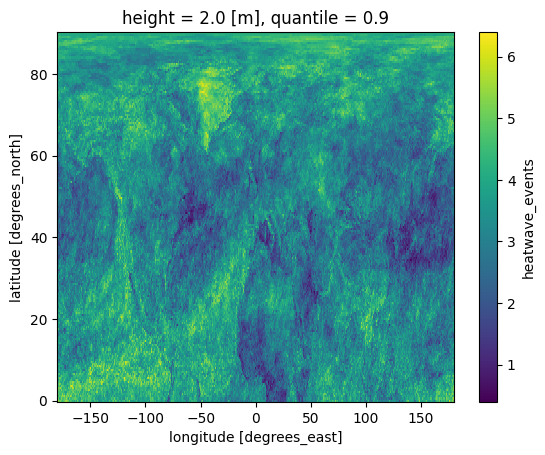

In [18]:
#hw_events_per_year.isel(time=0).plot()
hw_events_per_year.mean(dim='time').plot()#levels=np.arange(0,30,3))

In [19]:
# (c) duration per year — Dask-safe, no ndimage, no groupby on chunked labels
'''
# 0/ prep
x = hw_mask  # (time, lat, lon) boolean

# 1) find run starts
start = x & (~x.shift(time=1, fill_value=False))

# 2) numeric time index
idx = xr.DataArray(
    np.arange(x.sizes["time"], dtype=np.int64),
    coords={"time": x.time},
    dims="time",
)

# 3) forward-fill the start index across each run
start_idx = idx.where(start)                     # start index at run starts, NaN elsewhere
start_idx_ffill = start_idx.ffill("time")        # propagate start index forward within runs

# 4) run length per day (only for True days; zeros otherwise)
run_len = xr.where(x, (idx - start_idx_ffill + 1), 0).astype("int32")

# 5a) yearly mean run length
hw_mean_duration_per_year = run_len.resample(time="YS").mean("time").astype("int32")
hw_mean_duration_per_year.name = "mean_heatwave_duration"
# 5b) yearly maximum run length
#hw_max_duration_per_year = run_len.resample(time="YS").max("time").astype("int32")
#hw_max_duration_per_year.name = "max_heatwave_duration"
'''
#new routines
# Boolean mask of heatwave days (already min_duration>=3), shape (time, lat, lon)
x = hw_mask

# run starts (you already had this)
start = x & (~x.shift(time=1, fill_value=False))

# numeric time index
idx = xr.DataArray(np.arange(x.sizes["time"], dtype=np.int64),
                   coords={"time": x.time}, dims="time")

# forward-fill start index and compute per-day run length
start_idx = idx.where(start)
start_idx_ffill = start_idx.ffill("time")
run_len = xr.where(x, (idx - start_idx_ffill + 1), 0).astype("int32")

# --- NEW: pick event lengths only at run ENDS ---
end = x & (~x.shift(time=-1, fill_value=False))          # last day of each event
event_len = run_len.where(end)                            # lengths at ends; NaN elsewhere

# summarize by YEAR OF THE END DAY (change "YS" to "AS-Dec" if you prefer)
hw_mean_duration_per_year = event_len.resample(time="YS").mean("time")
hw_max_duration_per_year  = event_len.resample(time="YS").max("time")

# optional: long-term means/maps
mean_of_yearly_means = hw_mean_duration_per_year.mean("time")
max_of_yearly_max    = hw_max_duration_per_year.max("time")

In [20]:
#hw_max_duration_per_year.mean(dim='time').plot()#levels=np.arange(0,30,3))
#mean_of_yearly_means.plot()#levels=np.arange(0,10,1))

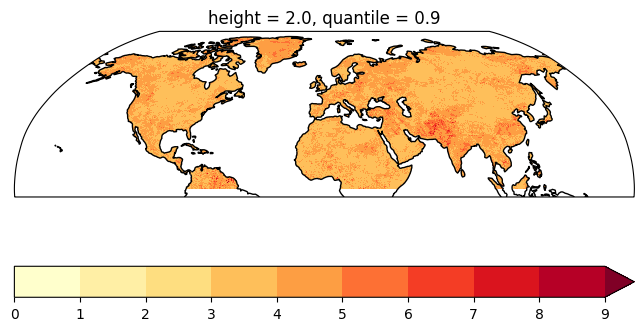

In [21]:
mean_hw_duration=hw_mean_duration_per_year.sel(time=slice('2020','2023')).mean(dim='time') 
# --- Apply mask & plot ---
mean_hw_duration_land = mean_hw_duration.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_duration_land.plot(
    ax=ax1,
    cmap='YlOrRd',
    levels=np.arange(0, 10, 1),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()

In [22]:
### distribution


In [18]:
# (d) mean intensity (tmax - Tr90d) over heatwave days per year
intensity = (drop_feb29(tmax) - tr_full).where(hw_mask)
mean_intensity_per_year = intensity.resample(time="YS").mean("time")
mean_intensity_per_year.name = "mean_intensity_above_Tr90d"

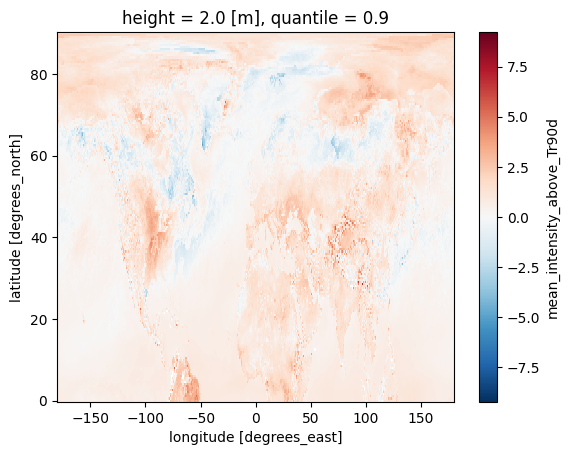

In [19]:
mean_intensity_per_year.mean(dim='time').plot()#levels=np.arange(0,30,3))

In [48]:
# (e) Season-split — returns a [season, time, lat, lon] boolean mask
#season_hw = split_heatwaves_by_season(hw_mask)
### error with saved hw mask (14.10.2025)
season_hw = split_heatwaves_by_season(hw_mask.chunk(dict(time=-1)))

# Example: counts full period
#season_counts = season_hw.sum("time")  # days per season at each gridpoint
#da_s = season_counts.sel(season='JJA').compute()  # or .load() / .persist()

### average per season
jja = season_hw.sel(season="JJA")                 # includes May–Sep by design
jja_yearly = jja.groupby("time.year").sum("time") # days per year at each gridpoint
jja_yearly_mean = jja_yearly.mean("year").compute()         # average per year
jja_yearly_mean.attrs["units"] = "days per season"
jja_yearly_mean.attrs["long_name"] = "Mean JJA heatwave days per season"
print(jja_yearly_mean.max().values)

13.4


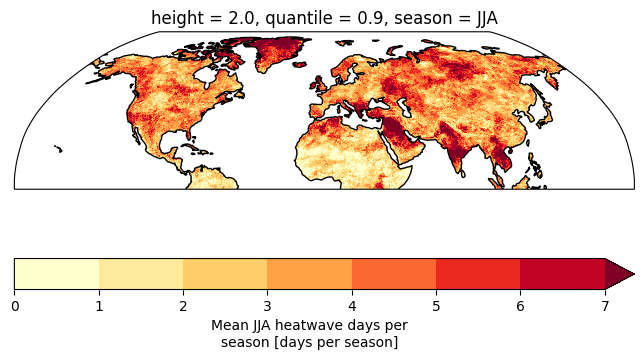

In [49]:
# --- Apply mask & plot ---
da_s_land = jja_yearly_mean.where(mask_da)

proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

p = da_s_land.plot.pcolormesh(ax=ax1,
                       cmap='YlOrRd',
#                       vmin=0, vmax=50,         # instead of levels=...
                       levels=np.arange(0, 8, 1),
                       transform=ccrs.PlateCarree(),
                       add_colorbar=True,
                       cbar_kwargs={'orientation': 'horizontal'},
                       rasterized=True)          # speeds up vector backends
# Add features
#ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
#                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
ax1.coastlines('110m')                            # lighter than land polygons

In [50]:
### saving season
jja.to_netcdf('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/hw_mask_simclim_jja.nc')

In [ ]:
### compute duration
# hw_mask: bool [time, lat, lon] from detect_heatwaves (already min_duration >= 3)
ds = durations_full_event_per_season_year(hw_mask.chunk(dict(time=-1)))
ds

# Example: JJA mean duration map for 1981 at max over years present
#jja_mean_1981 = ds["mean_duration"].sel(season="JJA", season_year=1981)

# Climatological mean over years (per season)
#jja_mean_clim = ds["mean_duration"].sel(season="JJA").mean("season_year")


In [ ]:
dur_jja_mean_clim = ds["mean_duration"].sel(season="JJA").mean("season_year")
dur_jja_yearly_mean.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/dur_jja_yearly_mean.nc')

In [ ]:
# --- Apply mask & plot ---
mean_hw_duration_land = dur_jja_mean_clim.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_duration_land.plot(
    ax=ax1,
    cmap='YlOrRd',
    levels=np.arange(0, 10, 1),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()

# Tracking heatwaves

In [5]:
def calculate_smoothed_field(
    data,
    passes,
    weights=np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]]),
    mode="wrap",
    *args,
    **kwargs
):
    """
    Calculate smoothed field based on a two-dimensional weight kernel
    and multiple smoothing passes. Default weight kernel is a 3x3
    5-point smoothing with double-weighted centre. The arguments
    "weight" and "mode" must be accepted by scipy.ndimage.convolve.
    Values at the latitude border are always set to NaN.
    Dimension names ("time_name", "lon_name", "lat_name"), size ("ntime", "nlon", "nlat")
    and resolution ("dlon", "dlat") can be passed as key=value arguments.

    Parameters
    ----------
        data : xarray.DataArray
            data to smooth
        passes : int or float
            number of smoothing passes of the 5-point smoothing
        weigths : array_like, optional
            array of weight, two-dimensional
            (see scipy.ndimage.convolve function)
        mode : string, optional
            defines how the array is extended at boundaries
            (see scipy.ndimage.convolve function)

    Returns
    -------
        smoothed data: xarray.DataArray
            Data containing the smoothed field
    """

    # perform smoothing
    smoothed = []
    for step in data[kwargs["time_name"]]:
        temp = data.sel({kwargs["time_name"]: step})
        for p in range(passes):
            temp = ndimage.convolve(temp, weights=weights, mode=mode) / np.sum(weights)

        # set latitude border values to nan
        border_size = int(weights.shape[0] / 2 + 0.5)
        temp[np.arange(-border_size, border_size), :] = np.nan

        smoothed.append(temp)

    # define DataArray
    da = xr.DataArray(
        smoothed,
        coords=[
            data[kwargs["time_name"]],
            data[kwargs["lat_name"]],
            data[kwargs["lon_name"]],
        ],
    )

    # set name
    da.name = "smooth_" + data.name

    # assign attributes
    da = da.assign_attrs(data.attrs)
    da.attrs["smooth_passes"] = passes

    return da

In [6]:
# -----------------------
# Load data 
# -----------------------
# ERA5
#einpath = '/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5'
#efvar   = 't2m'     # filename variable key
#edvar   = 't2m'     # array variable name inside file
#etemp = xr.open_mfdataset(
#    f"{einpath}/{efvar}_day_20*_0p5deg.nc",
#    chunks={"time": 365, "lon": -1, "lat": -1}
#)[edvar].squeeze()

# ICON (already regridded to 0.5° from filename)
inpath = '/capstor/scratch/cscs/edolores/old_icon/t_2m/'
fvar   = 't_2m'
dvar   = 't_2m'
temp = xr.open_mfdataset(
    f"{inpath}/remap_{fvar}_*",
    chunks={"time": 365, "lon": -1, "lat": -1}
)[dvar].squeeze()

In [7]:
###
temp

<xarray.DataArray 't_2m' (time: 4383, lat: 360, lon: 720)> Size: 5GB
dask.array<getitem, shape=(4383, 360, 720), dtype=float32, chunksize=(365, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 35kB 2006-01-01T10:30:00 ... 2017-12-31T10...
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
    height   float64 8B 2.0
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: mean

In [8]:
# -----------------------
# Ensure same season selection (Apr–Oct) "we will use icon climatology"
# -----------------------
months_sel = [4,5,6,7,8,9,10]
temp  = temp.sel(time=temp["time.month"].isin(months_sel))
#etemp = etemp.sel(time=etemp["time.month"].isin(months_sel))

#### (Optional) ###########
### also slice ICON period if you like
temp = temp.sel(time=slice("2014-01-01", "2017-12-31")) ### Only 4 years

### select NH only
temp = temp.sel(lat=slice(0,90)) ### Only 4 years
###########################

# -----------------------
# Prepare time helpers
# -----------------------
t_icon   = temp.time
doy_icon = t_icon.dt.dayofyear

#t_era    = etemp.time
#doy_era  = t_era.dt.dayofyear

# Preallocate output with same shape as ICON
icon_std = xr.zeros_like(temp)

print('Standardizing ICON using ERA5 moving-window climatology & std (30-day DOY × ~8-year)')

# helper for circular day-of-year difference (handles wrap around)
def circ_doy_diff(a, b):
    # a, b are numpy arrays or scalars of day-of-year (1..366)
    d = np.abs(a - b)
    return np.minimum(d, 365 - d)

# -----------------------
# Main loop over ICON times; stats taken from ERA5
# -----------------------
for tt in range(t_icon.size):
    # 30-day window (±15 days) in DOY space on ERA5
    w_doy = circ_doy_diff(doy_icon.values, doy_icon.values[tt]) <= 15

    # 8-year window centered on ICON time[tt] (±1475 days) on ERA5
    w_time = np.abs((t_icon.values - t_icon.values[tt]).astype('timedelta64[D]')) <= np.timedelta64(1475, 'D')

    # Combined mask over ERA5 time
    vec = w_doy & w_time

    # Compute ERA5 climatology and std over that window
    # These broadcast over lat/lon (same 0.5° grid as ICON)
    # (If any std==0, avoid division by zero)
    clim = temp.isel(time=vec).mean('time')
    std  = temp.isel(time=vec).std('time')

    icon_std[tt, :, :] = xr.where(std > 0, (temp.isel(time=tt) - clim) / std, np.nan)

Standardizing ICON using ERA5 moving-window climatology & std (30-day DOY × ~8-year)


In [9]:
print('select months')
icon_std = icon_std.sel(time=icon_std.time.dt.month.isin([5,6,7,8,9])).compute()
icon_std

select months


<xarray.DataArray 't_2m' (time: 612, lat: 180, lon: 720)> Size: 317MB
array([[[-0.71188337, -0.6986437 , -0.2021159 , ...,  0.45034537,
          0.04895247, -0.18868645],
        [-1.0442734 , -0.4264516 ,  0.18313801, ...,  0.04129672,
         -0.31448486, -0.92791015],
        [-0.7686849 , -0.00379216,  0.47102416, ..., -0.3138487 ,
         -0.9711124 , -1.2697409 ],
        ...,
        [ 0.0342219 ,  0.03421926,  0.03421662, ...,  0.03197011,
          0.03315767,  0.03413305],
        [ 0.07412659,  0.0744155 ,  0.07471261, ...,  0.07349527,
          0.07366379,  0.07388306],
        [ 0.11062462,  0.11062191,  0.11062191, ...,  0.11062501,
          0.11062217,  0.11062208]],

       [[-1.0095396 , -1.0015047 , -1.118743  , ..., -0.14362638,
         -0.7672307 , -1.016427  ],
        [-1.2125907 , -1.3091742 , -1.302549  , ..., -0.05619486,
         -0.86783415, -1.0935079 ],
        [-1.2049688 , -1.4136286 , -1.2618423 , ..., -0.6520242 ,
         -1.1643012 , -1.1950365 ],
...
        [ 0.7541418 ,  0.7541401 ,  0.75413954, ...,  0.7458647 ,
          0.75018555,  0.75383866],
        [ 0.81664   ,  0.81787544,  0.81920105, ...,  0.8130643 ,
          0.81422275,  0.8154272 ],
        [ 0.8670752 ,  0.867075  ,  0.8670746 , ...,  0.8671029 ,
          0.86708915,  0.8670754 ]],

       [[ 0.6686919 ,  0.68149716,  0.76664025, ...,  0.7018143 ,
          0.6317548 ,  0.6831308 ],
        [ 0.47621423,  0.5221479 ,  0.5934607 , ...,  0.5696982 ,
          0.40902913,  0.37871706],
        [ 0.46134388,  0.72195184,  0.8950722 , ...,  0.351785  ,
          0.1942408 ,  0.17388044],
        ...,
        [ 1.1376344 ,  1.1376377 ,  1.1376365 , ...,  1.1315632 ,
          1.1347331 ,  1.1374105 ],
        [ 1.1424949 ,  1.1452713 ,  1.1480454 , ...,  1.1341007 ,
          1.1369016 ,  1.139706  ],
        [ 1.1517854 ,  1.1517917 ,  1.1517975 , ...,  1.1517942 ,
          1.1517868 ,  1.1517855 ]]], shape=(612, 180, 720), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 5kB 2014-05-01T10:30:00 ... 2017-09-30T10:...
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 1kB 0.25 0.75 1.25 1.75 ... 88.25 88.75 89.25 89.75
    height   float64 8B 2.0
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: mean

In [14]:
#icon_std.isel(time=300).plot()
print('write anomalies to netcdf')
icon_std.to_netcdf(inpath+'/ICON_'+fvar+'_NH_19592023_AMJJASO_daily_MA_simclim.nc')

write anomalies to netcdf


In [10]:
##### Smoothing spatially
smooth_passes=5
icon_std_smooth = calculate_smoothed_field(
        icon_std, smooth_passes, time_name='time', lat_name='lat', lon_name='lon')
# Rename the DataArray
icon_std_smooth= icon_std_smooth.rename('t_2m')
icon_std_smooth

<xarray.DataArray 't_2m' (time: 612, lat: 180, lon: 720)> Size: 635MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-0.56728959, -0.19781678,  0.17152056, ..., -0.58315635,
         -0.76567037, -0.78081098],
        ...,
        [ 0.01411533,  0.01580873,  0.02271997, ...,  0.03502665,
          0.02678488,  0.01906121],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.21559837, -1.25362997, -1.24131266, ..., -0.53671111,
         -0.90151565, -1.11459962],
...
        [ 0.73341384,  0.73411224,  0.73536785, ...,  0.72056852,
          0.72468155,  0.72993867],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.51253078,  0.64648196,  0.76595685, ...,  0.4860022 ,
          0.39180043,  0.41016537],
        ...,
        [ 1.12649075,  1.12971613,  1.13326629, ...,  1.12256541,
          1.12153282,  1.12351689],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], shape=(612, 180, 720))
Coordinates:
  * time     (time) datetime64[ns] 5kB 2014-05-01T10:30:00 ... 2017-09-30T10:...
  * lat      (lat) float64 1kB 0.25 0.75 1.25 1.75 ... 88.25 88.75 89.25 89.75
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: mean
    smooth_passes:  5

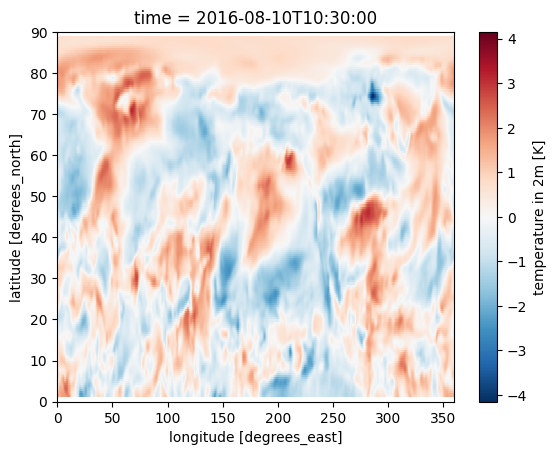

In [11]:
### we are going to use "icon_std_smooth"
#snap=icon_std.sel(time='2019-08-10',drop=True)
snap=icon_std_smooth.sel(time='2016-08-10',drop=True)
snap.plot()

/users/edolores/.env_icon/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


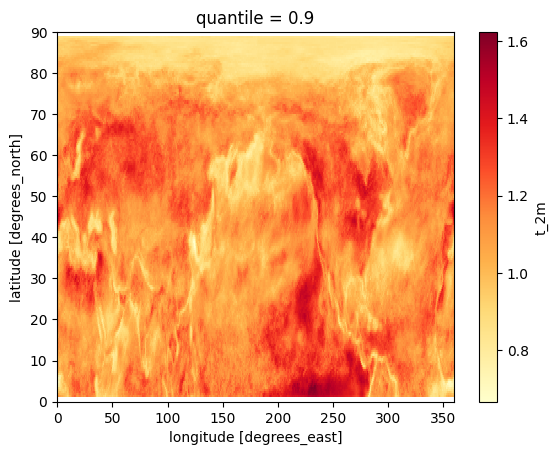

In [12]:
#q90 =icon_std.quantile(0.9, dim="time")
q90 =icon_std_smooth.quantile(0.9, dim="time")
q90.plot(cmap='YlOrRd')

ValueError: DataArray must be 2d

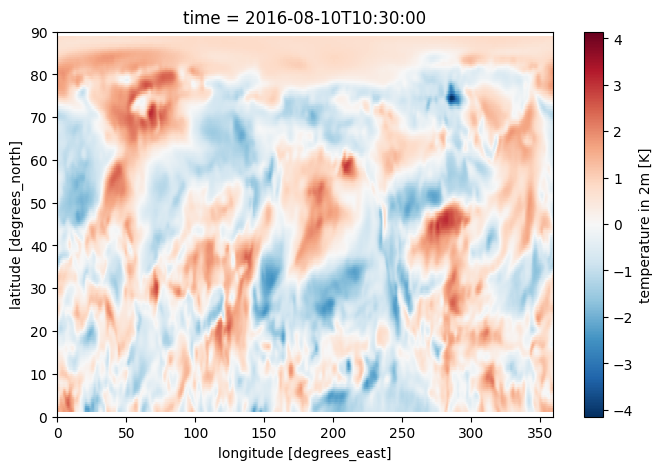

In [25]:
# Start plot of the field
fig, ax = plt.subplots(figsize=(8, 5))
snap.plot(ax=ax, cmap="RdBu_r")  # base field

# Overlay contour line(s) where values exceed q90
#(snap.isel(time=0, drop=True) > q90).plot.contour(ax=ax, colors="grey", linewidths=1.5)
(snap > q90).plot.contour(ax=ax, colors="grey", linewidths=1.5)

plt.title("2022-08-10 with regions above 90th percentile (red contours)")
plt.show()

In [13]:
##### Save binary files 1/0

In [14]:
#binary=xr.where ( icon_std> q90, 1, 0)
binary=xr.where ( icon_std_smooth> q90, 1, 0)
binary=binary.sortby('lat') ### for destinE lat descding --> ascending
binary

<xarray.DataArray 't_2m' (time: 612, lat: 180, lon: 720)> Size: 635MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(612, 180, 720))
Coordinates:
  * time      (time) datetime64[ns] 5kB 2014-05-01T10:30:00 ... 2017-09-30T10...
  * lat       (lat) float64 1kB 0.25 0.75 1.25 1.75 ... 88.25 88.75 89.25 89.75
  * lon       (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
    quantile  float64 8B 0.9

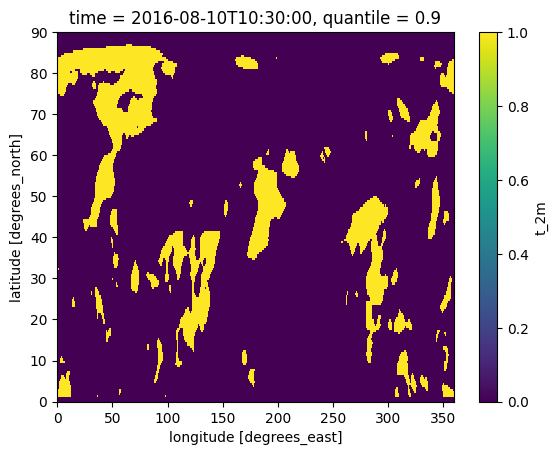

In [15]:
binary.sel(time='2016-08-10',drop=True).plot()

In [16]:
### Track heatwaves
### For pressure level temperature
#binary=binary.isel(level=0,drop=True)
outpath='/capstor/scratch/cscs/edolores/old_icon/Heatwaves/MA_TS/'

In [30]:
### intitate
anom = contrack()
anom.read_xarray(binary.to_dataset())

def _get_resolution_patched(self, dim, force=False):
    # Try to get a pandas Index (DatetimeIndex, Float64Index, etc.)
    idx = self.ds[dim].to_index()

    # Case 1: time-like coordinate → return timedelta64[h]
    if isinstance(idx, (pd.DatetimeIndex, pd.TimedeltaIndex)):
        diffs = idx[1:] - idx[:-1]  # TimedeltaIndex
        delta = np.unique(diffs.to_numpy(dtype='timedelta64[h]'))
        return delta[0]

    # Case 2: numeric coordinate (e.g., degrees) → return float
    # (Work directly with numpy array to be robust to Index subclasses)
    arr = np.asarray(idx, dtype=float)
    diffs = np.diff(arr)
    # protect against tiny numerical noise
    delta = np.unique(np.round(diffs, 10))
    return float(delta[0])


# apply the patch
contrack._get_resolution = _get_resolution_patched

/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:129: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims[self._get_name_time()]


In [31]:
anom.set_up(force=True)
anom.ds=anom.ds.compute()

INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'



In [32]:
# Finally, track temperature anomalies (>=1, 50% overlap twosided, 3 timesteps persistence (here 3 days))
anom.run_contrack(variable=dvar,
                   threshold=1,
                   gorl='>=',
                   overlap=0.5,
                   persistence=3,
                   twosided=True)

### save blobs 
anom.to_netcdf(outpath+'HW_ICON_NH_20202024_AMJJASO_daily_MA_simclim.nc')

INFO: 
Run ConTrack 
########### 
    threshold:    >= 1 
    overlap:      0.5 
    persistence:  3 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Find individual contours...
INFO: Apply overlap...
/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:704: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  weight_grid = np.ones((self.ds.dims[self._latitude_name], self.ds.dims[self._longitude_name])) * np.array((111 * self._dlat * 111 * self._dlon * weight_lat)).astype(np.float32)[:, None]
INFO: Apply persistence...
INFO: Create new variable 'flag'...
INFO: Running contrack... DONE
472 contours tracked


In [33]:
### lifecycle
anom_df = anom.run_lifecycle(flag='flag', variable=dvar)
anom_df.to_csv(outpath+'HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv', index=False)

INFO: 
Run Lifecycle 
########### 
    flag:    flag
    variable:    t_2m
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:848: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  weight_grid = np.ones((self.ds.dims[self._latitude_name], self.ds.dims[self._longitude_name])) * np.array((111 * self._dlat * 111 * self._dlon * weight_lat)).astype(np.float32)[:, None]
/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:860: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.

In [34]:
###Frequency
mean_hw = xr.where(anom['flag']>1,1,0).mean(dim='time')*100
#mean_hw.plot(cmap='YlOrRd', levels=np.arange(0, 5, 0.5))

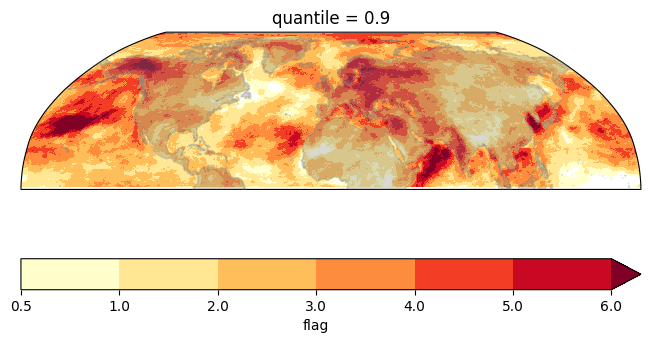

In [35]:
proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})
plot=mean_hw.plot(ax=ax1, cmap='YlOrRd', levels=[0.5,1,2,3,4,5,6],transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})
# Add features
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)